In [2]:
import json
from factorio_rcon import RCONClient
from FactoryVerse.dsl.dsl import (
    walking,
    crafting,
    research,
    inventory,
    reachable,
    ghost_manager,
    configure, # configuration bit
    playing_factorio, # context manager?
    map_db, # duckdb data layer for map
    enable_logging,
)
from FactoryVerse.dsl.types import MapPosition, Direction

In [3]:
rcon_client = RCONClient("localhost", 27100, "factorio")
interfaces = json.loads(rcon_client.send_command("/c rcon.print(helpers.table_to_json(remote.interfaces))"))
print(interfaces["agent_1"])
agent_udp_port = 24389
rcon_client.send_command("/c rcon.print('hello world')") # produces a warning and doesnt execute
rcon_client.send_command("/c rcon.print('hello world')") # this executes, now commands will work
initial_inventory = '{["burner-mining-drill"] = 3, ["stone-furnace"] = 3, ["wood"] = 1}'
# rcon_client.send_command(
#     f"/c local res = remote.call('agent', 'create_agent', {agent_udp_port}, true, false, nil, {initial_inventory})"
# )
interfaces = json.loads(rcon_client.send_command("/c rcon.print(helpers.table_to_json(remote.interfaces))"))
configure(rcon_client, "agent_1", agent_udp_port = agent_udp_port)


with playing_factorio():
    await map_db.load_snapshots()

{'walk_to': True, 'stop_walking': True, 'mine_resource': True, 'stop_mining': True, 'craft_enqueue': True, 'craft_dequeue': True, 'set_entity_recipe': True, 'set_entity_filter': True, 'set_inventory_limit': True, 'take_inventory_item': True, 'put_inventory_item': True, 'place_entity': True, 'pickup_entity': True, 'remove_ghost': True, 'teleport': True, 'inspect': True, 'get_inventory_items': True, 'get_position': True, 'get_placement_cues': True, 'get_chunks_in_view': True, 'get_recipes': True, 'get_technologies': True, 'enqueue_research': True, 'cancel_current_research': True, 'get_research_queue': True, 'get_reachable': True, 'inspect_entity': True, 'inspect_state': True}
DEBUG: Loaded 13 recipes into registry.
DEBUG: Loaded 196 technologies into tech_tree.
[PrototypeDataManager] Loading prototype data from /Users/harshitsharma/Code/exp/FactoryVerse/factorio-data-dump.json
[PrototypeDataManager] Applying filters...
[PrototypeDataManager] Cached 75 entities, 113 recipes, 85 items, 33 

In [4]:

with playing_factorio():
    # Find iron ore resources nearby and mine some
    iron_resources = reachable.get_resources(resource_name="iron-ore")
    print(f"Found {len(iron_resources)} iron ore tiles nearby")
    
    # Mine iron ore - need to mine multiple times (max 25 per operation)
    if iron_resources:
        iron = iron_resources[0]
        print(f"Mining iron ore at {iron.position}")
        # Mine 25 iron ore (the max per operation)
        result = await iron.mine()
        print(f"Mined: {result}")
        
        # Check inventory
        iron_count = inventory.get_total("iron-ore")
        print(f"Iron ore in inventory: {iron_count}")


Found 1 iron ore tiles nearby
Mining iron ore at MapPosition(x=23.5, y=84.5)
Mined: [ItemStack(name='iron-ore', count=25)]
Iron ore in inventory: 25


In [5]:
dir(map_db.sync)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'connection',
 'ensure_synced',
 'get_entities',
 'get_entity',
 'load_snapshots',
 'load_snapshots_sync',
 'sync']

In [3]:
with playing_factorio():
    furnace_item = inventory.get_item('stone-furnace')
    furnace_item.place(MapPosition(5, 0))

🔔 UDP Dispatcher: Received entity_operation - 2 handlers
   Payload: op=created, key=(stone-furnace:5,0), name=stone-furnace
🔔 UDP Dispatcher: Received entity_operation - 2 handlers
   Payload: op=created, key=(stone-furnace:5,0), name=stone-furnace


In [4]:
with playing_factorio():
    await map_db.sync()
    res = map_db.connection.sql("""
        SELECT * FROM map_entity
        WHERE entity_name = 'stone-furnace'
    """).fetchall()
res

[('(stone-furnace:5,0)',
  {'x': 5.0, 'y': 0.0},
  'stone-furnace',
  b'\x02\x04\x00\x00\x00\x00\x00\x00\x00\x80\x86@\x00\x00\x80\xbf\x00\x80\xb9@\x00\x00\x80?\x02\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd0\x10@\x00\x00\x00\x00\x00\x00\xf0\xbf\x00\x00\x00\x00\x00\xd0\x10@\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x000\x17@\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x000\x17@\x00\x00\x00\x00\x00\x00\xf0\xbf\x00\x00\x00\x00\x00\xd0\x10@\x00\x00\x00\x00\x00\x00\xf0\xbf',
  None)]

In [5]:
with playing_factorio():
    furnaces = map_db.get_entities("""
        SELECT * FROM map_entity
        WHERE entity_name = 'stone-furnace'
    """)
furnaces

[RemoteViewEntity[Furnace](name='stone-furnace', position=(5.0, 0.0))]

In [7]:
with playing_factorio():
    furnaces = reachable.get_entities('stone-furnace')
furnaces

[Furnace(name='stone-furnace', position=(5, 0), direction=NORTH)]

In [ ]:
furnaces

In [5]:
with playing_factorio():
    res = inventory.get_item("stone-furnace")
    furnace = res.place(MapPosition(0, 2))

In [7]:
furnaces

┌──────────────────────┬────────────────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [4]:
# recipes = json.loads(rcon_client.send_command("""/c 
# local res = remote.call('agent_1', 'get_recipes');
# rcon.print(helpers.table_to_json(res));
# """))
# recipes
# rcon_client.send_command(
#     '/c remote.call("admin", "add_items", 1, {["coal"]=10, ["transport-belt"]=10, ["burner-mining-drill"]=4})'
# )
with playing_factorio():
    # await walking.to(MapPosition(-50, 70))
    furnaces = reachable.get_entities()
    for furnace in furnaces:
        print(furnace.inspect())


Container(crash-site-spaceship) at (-5.0, -6.0)
  Status: broken
  Contents: firearm-magazine: 8
BaseEntity(character) at (0.0, 0.0)
  Status: unknown


In [5]:
furnace?

Type:        BaseEntity
String form: BaseEntity(name='character', position=(0, 0), direction=NORTH)
File:        ~/Code/exp/FactoryVerse/src/FactoryVerse/dsl/entity/base.py
Docstring:  
Base class for all entities.

Entities are things placed in the world with position and direction.
They have prototypes that define their properties and behavior.

**For Agents**: Entities are objects in the game world (furnaces, drills, chests, etc.).
Use inspect() to check their status, and entity-specific methods to interact with them.

In [5]:
with playing_factorio():
    res = furnaces[1].pickup()

In [6]:
print(res)

[ItemStack(name='stone-furnace', count=1), ItemStack(name='coal', count=15), ItemStack(name='iron-ore', count=1), ItemStack(name='iron-plate', count=49)]


In [7]:
with playing_factorio():
    furnaces = reachable.get_entities("burner-mining-drill")
    res = inventory.get_item("wooden-chest")
res

In [9]:
MapPosition(x=93.5, y=77.5) in reachable_positions

True

In [18]:
async def try_placing_coal_loop():
    with playing_factorio():
        drill_name = "burner-mining-drill"
        if inventory.get_total(drill_name) < 4:
            print(f"Dont have enough {drill_name}, Need 4 for a loop")
            return
        drill_item = inventory.get_item(drill_name)
        my_position = reachable.get_current_position()
        if drill_item:
            reachable_positions = drill_item.get_placement_cues("coal").reachable_positions
            first_position = [pos for pos in reachable_positions if my_position.distance(pos)<4][0]
            drill_on_map = drill_item.place(first_position, direction=Direction.NORTH)
            next_direction = drill_on_map.direction.turn_right()
            next_position = drill_on_map.get_valid_output_positions(drill_on_map)[0]
        if drill_on_map:
            for _ in range(3):
                drill_item = inventory.get_item(drill_name)
                drill_on_map = drill_item.place(next_position, direction=next_direction)
                if drill_on_map:
                    next_position = drill_on_map.get_valid_output_positions(drill_on_map)[0]
                    next_direction = drill_on_map.direction.turn_right()
        drills = reachable.get_entities("burner-mining-drill")
        for drill in drills:
            print(drill.inspect())
await try_placing_coal_loop()

BurnerMiningDrill(burner-mining-drill) at (88.0, 68.0)
  Status: no-fuel
  Mining Progress: 0.0
  Heat: 0/2667 (0.0%)
  Fuel Inventory: (empty)
BurnerMiningDrill(burner-mining-drill) at (90.0, 68.0)
  Status: no-fuel
  Mining Progress: 0.0
  Heat: 0/2667 (0.0%)
  Fuel Inventory: (empty)
BurnerMiningDrill(burner-mining-drill) at (88.0, 70.0)
  Status: no-fuel
  Mining Progress: 0.0
  Heat: 0/2667 (0.0%)
  Fuel Inventory: (empty)
BurnerMiningDrill(burner-mining-drill) at (90.0, 70.0)
  Status: no-fuel
  Mining Progress: 0.0
  Heat: 0/2667 (0.0%)
  Fuel Inventory: (empty)


In [12]:
drills

[BurnerMiningDrill(name='burner-mining-drill', position=(88, 68), direction=EAST),
 BurnerMiningDrill(name='burner-mining-drill', position=(90, 68), direction=SOUTH),
 BurnerMiningDrill(name='burner-mining-drill', position=(88, 70), direction=NORTH),
 BurnerMiningDrill(name='burner-mining-drill', position=(90, 70), direction=WEST)]

In [20]:
inventory.get_item_stacks?

Signature:
inventory.get_item_stacks(
    item_name: str,
    count: Union[int, Literal['half', 'full']],
    number_of_stacks: Union[int, Literal['max']] = 'max',
    strict: bool = False,
) -> List[FactoryVerse.dsl.item.base.ItemStack]
Docstring: Get item stacks for a specific item.
File:      ~/Code/exp/FactoryVerse/src/FactoryVerse/dsl/dsl.py
Type:      method

In [4]:
dir(drill)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_factory',
 '_prototype_cache',
 '_raw_position',
 'add_fuel',
 'agent_id',
 'bounding_box',
 'direction',
 'get_search_area',
 'get_valid_output_positions',
 'inspect',
 'name',
 'output_position',
 'pickup',
 'position',
 'prototype',
 'take_products',
 'tile_height',
 'tile_width']

In [8]:
async def try_placing_coal_loop():
    with playing_factorio():
        drill_name = "burner-mining-drill"
        if inventory.get_total(drill_name) < 4:
            print(f"Dont have enough {drill_name}, Need 4 for a loop")
            return
        drill_item = inventory.get_item(drill_name)
        my_position = reachable.get_current_position()
        if drill_item:
            reachable_positions = drill_item.get_placement_cues("coal").reachable_positions
            first_position = [pos for pos in reachable_positions if my_position.distance(pos)<4][0]
            drill_on_map = drill_item.place(first_position, direction=Direction.NORTH)
            next_direction = drill_on_map.direction.turn_right()
            next_position = drill_on_map.get_valid_output_positions(drill_on_map)[0]
        if drill_on_map:
            for _ in range(3):
                drill_item = inventory.get_item(drill_name)
                drill_on_map = drill_item.place(next_position, direction=next_direction)
                if drill_on_map:
                    next_position = drill_on_map.get_valid_output_positions(drill_on_map)[0]
                    next_direction = drill_on_map.direction.turn_right()
        drills = reachable.get_entities("burner-mining-drill")
        for drill in drills:
            print(drill.inspect())
await try_placing_coal_loop()

async def add_fuel_to_drills():
    with playing_factorio():
        total = inventory.get_total("coal")
        stacks = inventory.get_item_stacks("coal", count = min(1, total//4), number_of_stacks=4)
        drills = reachable.get_entities("burner-mining-drill")
        for drill, stack in zip(drills, stacks):
            drill.add_fuel(stack)
            print(drill.inspect())
    
await add_fuel_to_drills()

async def get_coal_from_loop():
    with playing_factorio():
        drills = reachable.get_entities("burner-mining-drill")
        print("Before:", inventory.get_total("coal"))
        for drill in drills:
            drill.take_products()
            print(drill.inspect())
        print("After:", inventory.get_total("coal"))
await get_coal_from_loop()

BurnerMiningDrill(burner-mining-drill) at (-54.0, 66.0)
  Status: working
  Mining Progress: 0.7
  Heat: 2667/2667 (100.0%)
  Fuel Inventory: (empty)
  Output: (empty)
BurnerMiningDrill(burner-mining-drill) at (-52.0, 66.0)
  Status: working
  Mining Progress: 0.7
  Heat: 2667/2667 (100.0%)
  Fuel Inventory: (empty)
  Output: (empty)
BurnerMiningDrill(burner-mining-drill) at (-54.0, 68.0)
  Status: working
  Mining Progress: 0.7
  Heat: 2667/2667 (100.0%)
  Fuel Inventory: (empty)
  Output: (empty)
BurnerMiningDrill(burner-mining-drill) at (-52.0, 68.0)
  Status: working
  Mining Progress: 0.7
  Heat: 2667/2667 (100.0%)
  Fuel Inventory: (empty)
  Output: (empty)


In [7]:
async def get_coal_from_loop():
    with playing_factorio():
        drills = reachable.get_entities("burner-mining-drill")
        print("Before:", inventory.get_total("coal"))
        for drill in drills:
            drill.take_products()
            print(drill.inspect())
        print("After:", inventory.get_total("coal"))
await get_coal_from_loop()

Before: 42
BurnerMiningDrill(burner-mining-drill) at (-54.0, 66.0)
  Status: working
  Mining Progress: 0.2
  Heat: 2667/2667 (100.0%)
  Fuel Inventory: (empty)
  Output: (empty)
BurnerMiningDrill(burner-mining-drill) at (-52.0, 66.0)
  Status: working
  Mining Progress: 0.2
  Heat: 2667/2667 (100.0%)
  Fuel Inventory: (empty)
  Output: (empty)
BurnerMiningDrill(burner-mining-drill) at (-54.0, 68.0)
  Status: working
  Mining Progress: 0.2
  Heat: 2667/2667 (100.0%)
  Fuel Inventory: (empty)
  Output: (empty)
BurnerMiningDrill(burner-mining-drill) at (-52.0, 68.0)
  Status: working
  Mining Progress: 0.1
  Heat: 2667/2667 (100.0%)
  Fuel Inventory: (empty)
  Output: (empty)
After: 58


In [9]:
with playing_factorio():
    drills = reachable.get_entities("stone-furnace")
    print("Before:", inventory.get_total("iron-plate"))
    for drill in drills:
        drill.take_products()
        print(drill.inspect())
    print("After:", inventory.get_total("iron-plate"))

Before: 0
Furnace(stone-furnace) at (91.0, 73.0)
  Status: working
  Recipe: iron-plate
  Currently Burning: coal
  Remaining Fuel Energy: 2121900 J
  Heat: 1600/1600 (100.0%)
  Fuel: coal: 49
  Input: iron-ore: 43
  Output: (empty)
After: 6

Before: 0
Furnace(stone-furnace) at (91.0, 73.0)
  Status: working
  Recipe: iron-plate
  Currently Burning: coal
  Remaining Fuel Energy: 2121900 J
  Heat: 1600/1600 (100.0%)
  Fuel: coal: 49
  Input: iron-ore: 43
  Output: (empty)
After: 6


In [8]:
drills[0].position, drills[0].tile_width, drills[0].tile_height, 

(EntityPosition(x=41, y=-11), 2, 2)

In [4]:
drills[0].direction, drills[0].direction.flip()

(<Direction.EAST: 4>, <Direction.WEST: 12>)

In [4]:
poses = drills[0].get_valid_output_positions(drills[0])
poses

[MapPosition(x=43.0, y=-11.0), MapPosition(x=43.0, y=-12.0)]

In [5]:
with playing_factorio():
    poses = drills[0].get_valid_output_positions(drills[0])
    drill_item = inventory.get_item("burner-mining-drill")
    res = drill_item.place(poses[0], direction=drills[0].direction.flip())


In [4]:
with playing_factorio():
    coal_stack = inventory.get_item_stacks("coal", count=10)
    drill.add_fuel(coal_stack)


In [4]:
dir(drills[0])

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_factory',
 '_prototype_cache',
 '_raw_position',
 'add_fuel',
 'agent_id',
 'bounding_box',
 'direction',
 'get_search_area',
 'get_valid_output_positions',
 'inspect',
 'name',
 'output_position',
 'pickup',
 'position',
 'prototype',
 'tile_height',
 'tile_width']

In [6]:
for drill in drills:
    pos = f'{{{drill.position.x}, {drill.position.y}}}'
    
    res = rcon_client.send_command(f'''/c 
    local entity = game.surfaces[1].find_entity("{drill.name}", {pos})
    rcon.print(entity.name)
    rcon.print(helpers.table_to_json(entity.prototype.vector_to_place_result))
    rcon.print(entity.direction)
    ''')
    print(res)

burner-mining-drill
[-0.5,-1.3000000000000000444089209850062616169452667236328125]
12


In [21]:
drills[0].prototype

BurnerMiningDrillPrototype(_data={'type': 'mining-drill', 'name': 'burner-mining-drill', 'flags': ['placeable-neutral', 'player-creation'], 'resource_categories': ['basic-solid'], 'minable': {'mining_time': 0.3, 'result': 'burner-mining-drill'}, 'max_health': 150, 'collision_box': [[-0.7, -0.7], [0.7, 0.7]], 'selection_box': [[-1, -1], [1, 1]], 'mining_speed': 0.25, 'allowed_effects': {}, 'energy_source': {'type': 'burner', 'fuel_categories': ['chemical'], 'effectivity': 1, 'fuel_inventory_size': 1, 'emissions_per_minute': {'pollution': 12}}, 'energy_usage': '150kW', 'resource_searching_radius': 0.99, 'vector_to_place_result': [-0.5, -1.3], 'fast_replaceable_group': 'mining-drill', 'circuit_connector': [{'points': {'wire': {'red': [-0.125, 0.046875], 'green': [-0.25, 0.234375]}}}, {'points': {'wire': {'red': [-0.1875, -0.078125], 'green': [-0.3125, 0.109375]}}}, {'points': {'wire': {'red': [-0.171875, -0.015625], 'green': [-0.296875, 0.171875]}}}, {'points': {'wire': {'red': [-0.265625

TypeError: 'int' object is not callable

In [7]:
for drill in drills:
    print(drill.direction, drill.position, drill.output_position())
    

Direction.WEST EntityPosition(x=42, y=-9) MapPosition(x=40.5, y=-8.5)


In [5]:
with playing_factorio():
    print(inventory.item_stacks)

[ItemStack(name='burner-mining-drill', count=1), ItemStack(name='stone-furnace', count=1), ItemStack(name='wood', count=1)]


In [16]:
from typing import List, Iterator
from FactoryVerse.dsl.entity.base import BaseEntity

def get_valid_connection_positions(
    source_entity: BaseEntity,          # The existing entity (for collision check)
    drop_position: MapPosition,     # The specific point items land (39.5, -9.5)
    target_width: int,
    target_height: int
) -> List[MapPosition]:
    """
    Returns all legal center positions for a new entity such that:
    1. It catches the item at `drop_position`.
    2. It does not collide with `source_entity`.
    3. It aligns to the grid correctly (Even vs Odd sizes).
    """
    candidates = []

    # 1. Determine Grid Parity (0.0 for Even, 0.5 for Odd)
    snap_x = 0.5 if (target_width % 2 != 0) else 0.0
    snap_y = 0.5 if (target_height % 2 != 0) else 0.0

    # 2. Calculate the "Sliding Window" of valid centers
    # The center must be within (Drop ± Size/2)
    # We add a small epsilon to avoid floating point errors on exact edges
    min_cx = drop_position.x - (target_width / 2) + 0.01
    max_cx = drop_position.x + (target_width / 2) - 0.01
    
    min_cy = drop_position.y - (target_height / 2) + 0.01
    max_cy = drop_position.y + (target_height / 2) - 0.01

    # 3. Iterate through possible integer coordinates in that window
    # We look for integers, then apply the snap offset.
    start_x = math.floor(min_cx)
    end_x = math.ceil(max_cx)
    start_y = math.floor(min_cy)
    end_y = math.ceil(max_cy)

    for x in range(start_x, end_x + 1):
        for y in range(start_y, end_y + 1):
            # Apply parity (e.g., if width is 3, center must be X.5)
            # If width is 2, center must be X.0
            # We simply check if (x + snap_x) is the grid alignment we want.
            # Actually, simpler: just iterate grid points and check range.
            
            candidate_x = x if snap_x == 0.0 else x + 0.5
            candidate_y = y if snap_y == 0.0 else y + 0.5
            
            # Check if this specific grid center is actually within capture range
            if not (min_cx <= candidate_x <= max_cx): continue
            if not (min_cy <= candidate_y <= max_cy): continue

            candidate_pos = MapPosition(candidate_x, candidate_y)

            # 4. Check Collision with Source Entity
            # (You would check AABB overlap here)
            if not check_collision(source_entity, candidate_pos, target_width, target_height):
                candidates.append(candidate_pos)

    return candidates

In [18]:
get_valid_connection_positions(drills[0], drills[0].output_position(), drills[0].tile_width, drills[0].tile_height)

NameError: name 'check_collision' is not defined

In [11]:
import math
with playing_factorio():
    drill_item = inventory.get_item("burner-mining-drill")
    if drills:
        pos = drills[0].output_position()
        res = drill_item.place(MapPosition(math.floor(pos.x), math.floor(pos.y)), direction = Direction.EAST)
        print(res)


BurnerMiningDrill(name='burner-mining-drill', position=(40, -9), direction=EAST)


In [15]:
len(set([(p.x,p.y) for p in res.reachable_positions]))

287

In [19]:
with playing_factorio():
    drill = inventory.get_item("burner-mining-drill")
    # if drill:
    #     res = drill.get_placement_cues("copper-ore")
    #     drill.place(res.reachable_positions[0])
    #     print(res)
    for pos in res.reachable_positions:
        placed = drill.place(pos)
        if res:
            placed.pickup()
        else:
            print("OH NO !", pos)


UDP message missing required 'status' field: {'event_type': 'action', 'action_id': 'place_entity_37337_1', 'agent_id': 1, 'action_type': 'place_entity', 'rcon_tick': 37337, 'tick': 37337, 'category': 'placement'}
UDP message missing required 'status' field: {'event_type': 'action', 'action_id': 'pickup_entity_37338_1', 'agent_id': 1, 'action_type': 'pickup_entity', 'rcon_tick': 37338, 'tick': 37338, 'category': 'entity_ops'}
UDP message missing required 'status' field: {'event_type': 'action', 'action_id': 'place_entity_37339_1', 'agent_id': 1, 'action_type': 'place_entity', 'rcon_tick': 37339, 'tick': 37339, 'category': 'placement'}
UDP message missing required 'status' field: {'event_type': 'action', 'action_id': 'pickup_entity_37340_1', 'agent_id': 1, 'action_type': 'pickup_entity', 'rcon_tick': 37340, 'tick': 37340, 'category': 'entity_ops'}
UDP message missing required 'status' field: {'event_type': 'action', 'action_id': 'place_entity_37341_1', 'agent_id': 1, 'action_type': 'plac

In [8]:
with playing_factorio():
    res = reachable.get_entities()
    for entity in (e for e in res if e.name == "stone-furnace"):
        if print(entity.inspect(False))


{'entity_name': 'stone-furnace', 'entity_type': 'furnace', 'position': {'x': 2, 'y': 0}, 'tick': 13331, 'status': 'working', 'recipe': 'iron-plate', 'crafting_progress': 0.18749999999998826, 'burner': {'heat': 1600, 'heat_capacity': 1600, 'remaining_burning_fuel': 2216400, 'currently_burning': None}, 'productivity_bonus': 0, 'energy': {'current': 1600, 'capacity': 0}, 'inventories': {'fuel': {'coal': 49}, 'input': {'iron-ore': 43}, 'output': {'iron-plate': 6}, 'chest': {'coal': 49}}}


In [13]:
with playing_factorio():
    for entity in (e for e in res if e.name == "stone-furnace"):
        entity.take_output()

In [15]:
with playing_factorio():
    print(inventory.get_total("iron-plate"))

24


In [12]:
dir(entity)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_factory',
 '_prototype_cache',
 '_raw_position',
 'add_fuel',
 'add_input_items',
 'agent_id',
 'bounding_box',
 'direction',
 'inspect',
 'name',
 'pickup',
 'position',
 'prototype',
 'take_output_items',
 'tile_height',
 'tile_width']

In [4]:
with playing_factorio():
    iron_ore_stack = inventory.get_item_stacks("iron-ore", 50, 1)
    done = res.add_input_items(iron_ore_stack[0])
    # dir(res)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_factory',
 '_prototype_cache',
 '_raw_position',
 'agent_id',
 'bounding_box',
 'direction',
 'inspect',
 'name',
 'pickup',
 'position',
 'prototype',
 'tile_height',
 'tile_width']

In [14]:
with playing_factorio():
    await res[1].mine()

In [6]:
with playing_factorio():
    await res[1].mine()

In [7]:
with playing_factorio():
    await res[0].mine()

In [3]:
with playing_factorio():
    await map_db.load_snapshots()

Loading base tables...
Loading water tiles...
  Found 4 water_init.jsonl files across all chunks
  Loading 1116 water tiles into water_tile table (global, across all chunks)
Loading resource tiles...


ConversionException: Conversion Error: Could not convert string 'iron-ore' to UINT8

✓ Integrated map saved to factorio_integrated_map_enhanced.png

Layer Composition:
  Layer 1 (Bottom): Water patches = 4
  Layer 2: Resource patches = 19
  Layer 3: Rocks = 110
  Layer 4 (Top): Trees = 7738

Visualization Features:
  • Polygon-based resource and water rendering
  • Patch labels show type + ID (e.g., 'C3' = Coal patch 3)
  • Distinct colors per resource type
  • Layered z-ordering for clear visibility
  • High-contrast design optimized for LLM vision


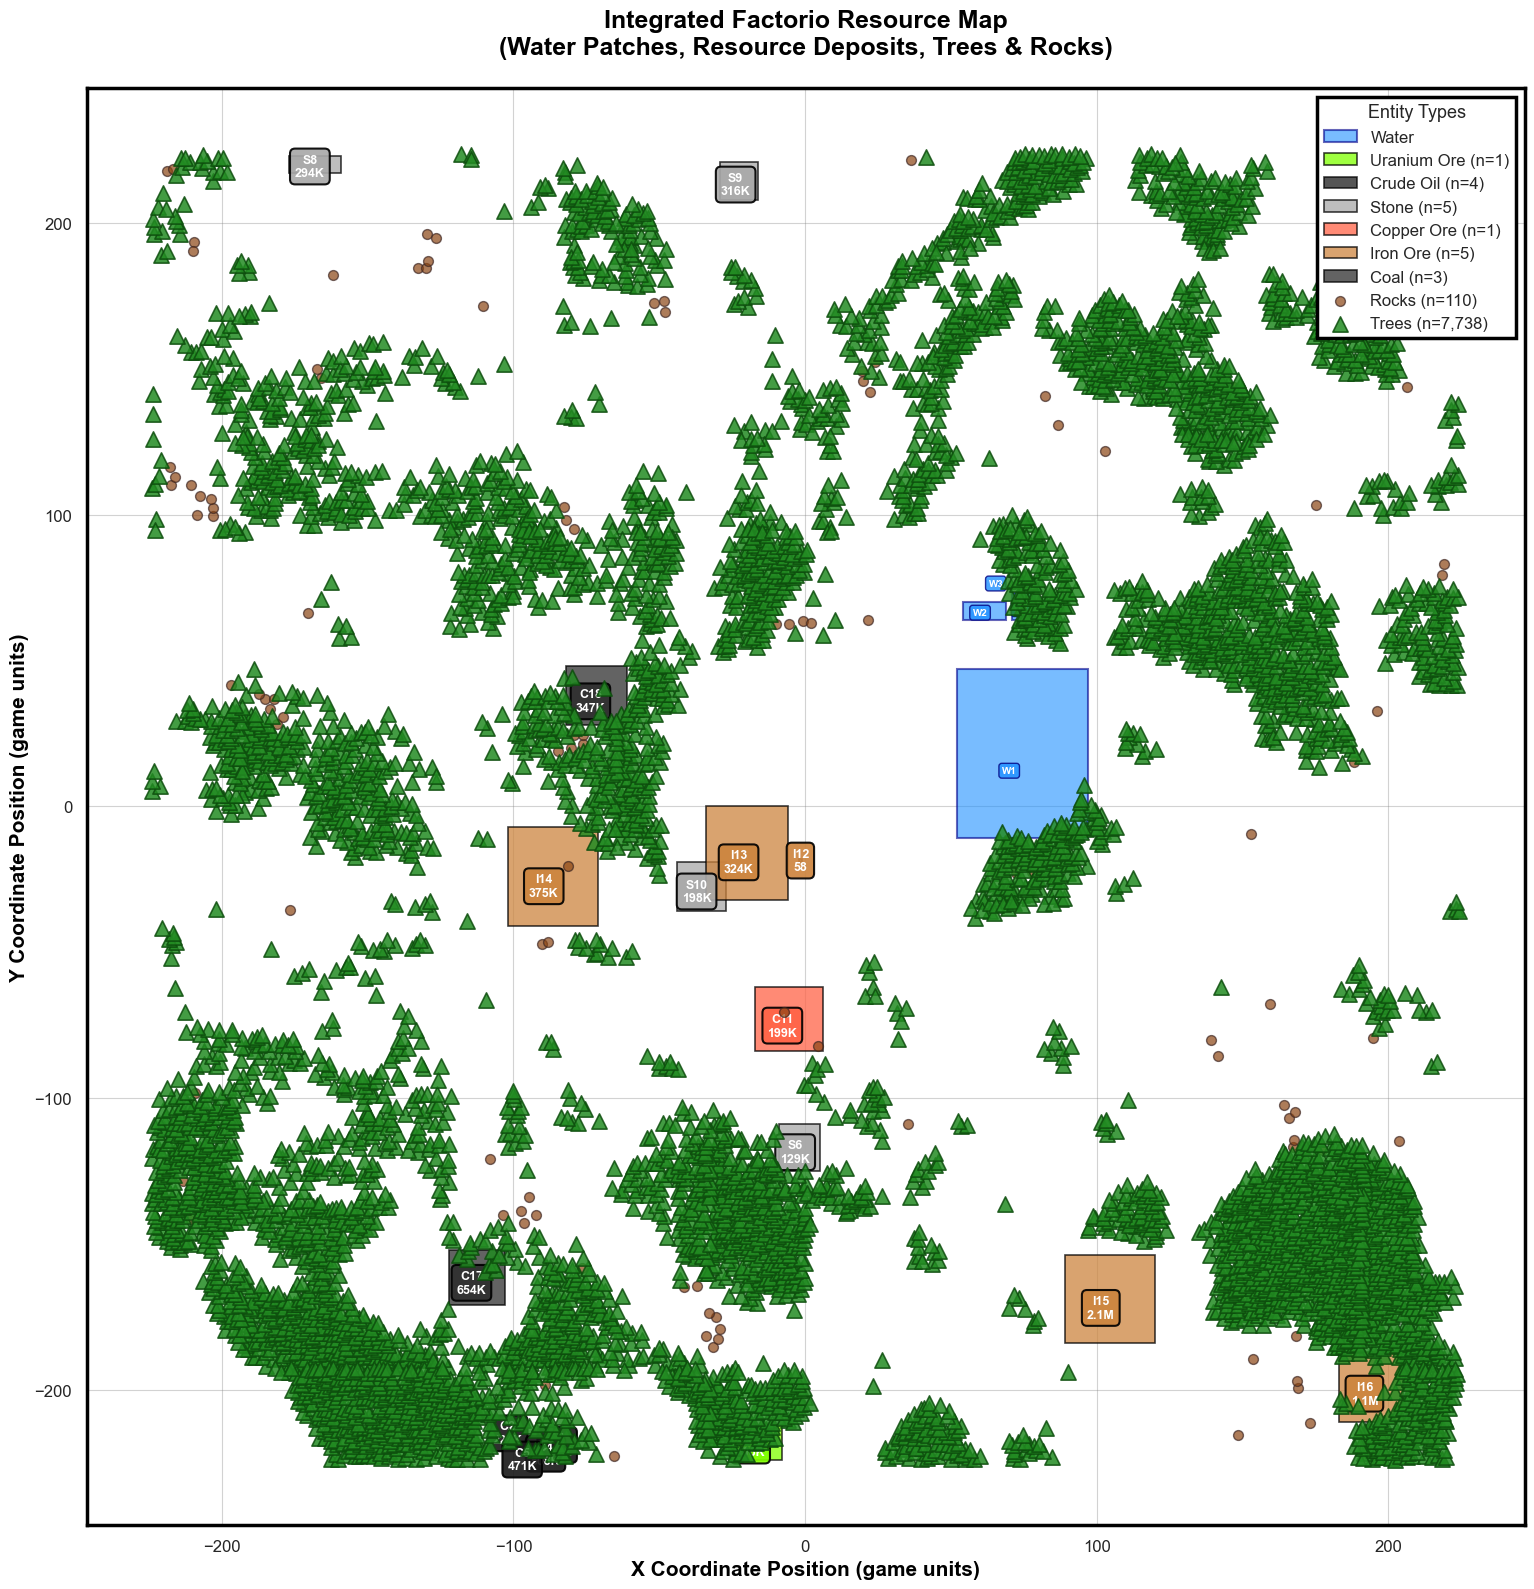

In [7]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely import wkt
import numpy as np

# Query trees and rocks (point entities)
trees_rocks_query = """
    SELECT 
        entity_key,
        name,
        type,
        position.x AS x,
        position.y AS y
    FROM resource_entity
    WHERE type = 'tree' OR type = 'simple-entity' OR name LIKE '%rock%'
"""

# Query resource patches (polygons)
resource_patches_query = """
    SELECT 
        patch_id,
        resource_name,
        tile_count,
        total_amount,
        ST_AsText(geom) as wkt_geom
    FROM resource_patch
    WHERE geom IS NOT NULL
"""

# Query water patches (polygons)
water_patches_query = """
    SELECT 
        patch_id,
        tile_count,
        ST_AsText(geom) as wkt_geom
    FROM water_patch
    WHERE geom IS NOT NULL
"""

# Execute queries
with playing_factorio():
    con = map_db.connection
    df_entities = con.execute(trees_rocks_query).df()
    df_resources = con.execute(resource_patches_query).df()
    df_water = con.execute(water_patches_query).df()

# ============================================================================
# STEP 2: Process point entities (trees and rocks)
# ============================================================================

trees = df_entities[df_entities['type'] == 'tree'].copy() if not df_entities.empty else pd.DataFrame()
rocks = df_entities[(df_entities['type'] == 'simple-entity') | 
                    (df_entities['name'].str.contains('rock', case=False, na=False))].copy() if not df_entities.empty else pd.DataFrame()

# ============================================================================
# STEP 3: Parse polygon geometries with Shapely
# ============================================================================

def parse_wkt_to_coords(wkt_string):
    """Parse WKT string to coordinate arrays using Shapely"""
    try:
        geom = wkt.loads(wkt_string)
        # Handle both Polygon and MultiPolygon
        if geom.geom_type == 'Polygon':
            x, y = geom.exterior.coords.xy
            return [(np.array(x), np.array(y))]
        elif geom.geom_type == 'MultiPolygon':
            # Return list of (x, y) coordinate pairs for each polygon
            coords_list = []
            for poly in geom.geoms:
                x, y = poly.exterior.coords.xy
                coords_list.append((np.array(x), np.array(y)))
            return coords_list
    except Exception as e:
        print(f"Error parsing WKT: {e}")
        return []

# Parse resource patches
resource_polygons = []
if not df_resources.empty:
    for idx, row in df_resources.iterrows():
        coords_list = parse_wkt_to_coords(row['wkt_geom'])
        for coords in coords_list:
            resource_polygons.append({
                'coords': coords,
                'resource_name': row['resource_name'],
                'patch_id': row['patch_id'],
                'tile_count': row['tile_count'],
                'total_amount': row['total_amount']
            })

# Parse water patches
water_polygons = []
if not df_water.empty:
    for idx, row in df_water.iterrows():
        coords_list = parse_wkt_to_coords(row['wkt_geom'])
        for coords in coords_list:
            water_polygons.append({
                'coords': coords,
                'patch_id': row['patch_id'],
                'tile_count': row['tile_count']
            })

# ============================================================================
# STEP 4: Define color scheme for resources
# ============================================================================

resource_colors = {
    'iron-ore': '#CD853F',      # Peru brown (high contrast)
    'copper-ore': '#FF6347',    # Tomato red-orange
    'coal': '#2F2F2F',          # Very dark gray
    'stone': '#A9A9A9',         # Dark gray
    'uranium-ore': '#7FFF00',   # Chartreuse green (radioactive!)
    'crude-oil': '#1C1C1C',     # Near black
}

water_color = '#1E90FF'  # Dodger blue

# ============================================================================
# STEP 5: Create the integrated visualization
# ============================================================================

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(20, 16))

# Plot water patches (lowest layer, z-order=1)
water_count = 0
for water_poly in water_polygons:
    x_coords, y_coords = water_poly['coords']
    coords_array = np.column_stack([x_coords, y_coords])
    
    patch = mpatches.Polygon(
        coords_array,
        facecolor=water_color,
        edgecolor='#00008B',  # Dark blue edge
        linewidth=1.5,
        alpha=0.6,
        zorder=1,
        label='Water' if water_count == 0 else ""
    )
    ax.add_patch(patch)
    
    # Add patch ID label at centroid
    centroid_x = np.mean(x_coords)
    centroid_y = np.mean(y_coords)
    ax.text(centroid_x, centroid_y, f'W{water_poly["patch_id"]}',
            fontsize=7, ha='center', va='center',
            color='white', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor=water_color, 
                     edgecolor='navy', alpha=0.8))
    water_count += 1

# Plot resource patches (middle layer, z-order=2)
resource_counts = {}
for res_poly in resource_polygons:
    x_coords, y_coords = res_poly['coords']
    coords_array = np.column_stack([x_coords, y_coords])
    
    res_name = res_poly['resource_name']
    color = resource_colors.get(res_name, '#FF0000')  # Default red if unknown
    
    # Track for legend (only label first occurrence)
    is_first = res_name not in resource_counts
    resource_counts[res_name] = resource_counts.get(res_name, 0) + 1
    
    patch = mpatches.Polygon(
        coords_array,
        facecolor=color,
        edgecolor='#000000',  # Black edge for definition
        linewidth=1.2,
        alpha=0.75,
        zorder=2,
        label=f'{res_name.replace("-", " ").title()} (n={len([p for p in resource_polygons if p["resource_name"]==res_name])})' if is_first else ""
    )
    ax.add_patch(patch)
    
    # Add resource label at centroid with total amount
    centroid_x = np.mean(x_coords)
    centroid_y = np.mean(y_coords)
    
    # Format total amount for readability (e.g., 2.4M, 500K)
    amount = res_poly['total_amount']
    if amount >= 1_000_000:
        amount_str = f'{amount/1_000_000:.1f}M'
    elif amount >= 1_000:
        amount_str = f'{amount/1_000:.0f}K'
    else:
        amount_str = f'{amount}'
    
    # Two-line label: Resource ID on top, amount below
    label_text = f'{res_name.split("-")[0][0].upper()}{res_poly["patch_id"]}\n{amount_str}'
    ax.text(centroid_x, centroid_y, label_text,
            fontsize=9, ha='center', va='center',
            color='white', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.4', facecolor=color, 
                     edgecolor='black', linewidth=1.5, alpha=0.92))

# Plot rocks (layer 3, z-order=3)
if not rocks.empty:
    ax.scatter(
        rocks['x'], 
        rocks['y'],
        c='#8B4513',
        s=50,
        alpha=0.7,
        marker='o',
        label=f'Rocks (n={len(rocks):,})',
        edgecolors='#3E2723',
        linewidths=1.0,
        zorder=3
    )

# Plot trees (top layer, z-order=4)
if not trees.empty:
    ax.scatter(
        trees['x'],
        trees['y'],
        c='#228B22',
        s=120,
        alpha=0.85,
        marker='^',
        label=f'Trees (n={len(trees):,})',
        edgecolors='#0D4D0D',
        linewidths=1.2,
        zorder=4
    )

# ============================================================================
# STEP 6: Add comprehensive statistics and styling
# ============================================================================

# Calculate statistics
total_resource_patches = len(resource_polygons)
total_water_patches = len(water_polygons)
total_point_entities = len(trees) + len(rocks)

# Enhanced labels and title
ax.set_xlabel('X Coordinate Position (game units)', 
              fontsize=15, fontweight='bold', color='black')
ax.set_ylabel('Y Coordinate Position (game units)', 
              fontsize=15, fontweight='bold', color='black')

title_text = ('Integrated Factorio Resource Map\n'
              '(Water Patches, Resource Deposits, Trees & Rocks)')
ax.set_title(title_text, fontsize=18, fontweight='bold', 
            pad=25, color='black')

# Enhanced legend
legend = ax.legend(
    loc='upper right',
    framealpha=1.0,
    fontsize=12,
    edgecolor='black',
    fancybox=False,
    shadow=False,
    frameon=True,
    title='Entity Types',
    title_fontsize=13,
    ncol=1
)
legend.get_frame().set_linewidth(2.5)

# High contrast styling
ax.grid(True, alpha=0.35, linestyle='-', linewidth=0.8, color='gray')
for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_linewidth(2.5)
    ax.spines[spine].set_color('black')

ax.tick_params(axis='both', which='major', labelsize=12, width=2.5, length=7)
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()

# Save
output_file = "factorio_integrated_map_enhanced.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='black')

print(f"✓ Integrated map saved to {output_file}")
print(f"\nLayer Composition:")
print(f"  Layer 1 (Bottom): Water patches = {total_water_patches}")
print(f"  Layer 2: Resource patches = {total_resource_patches}")
print(f"  Layer 3: Rocks = {len(rocks)}")
print(f"  Layer 4 (Top): Trees = {len(trees)}")
print(f"\nVisualization Features:")
print(f"  • Polygon-based resource and water rendering")
print(f"  • Patch labels show type + ID (e.g., 'C3' = Coal patch 3)")
print(f"  • Distinct colors per resource type")
print(f"  • Layered z-ordering for clear visibility")
print(f"  • High-contrast design optimized for LLM vision")

plt.show()

In [8]:
def find_nearest_resource(resource_name: str, resource_type: str = "tile"):
    """
    Find the nearest resource position from the agent's current location.
    
    Args:
        resource_name: Name of the resource (e.g., "iron-ore", "tree")
        resource_type: Either "tile" or "entity" (default: "tile")
    
    Returns:
        Dict with position (MapPosition) and distance, or None if not found
    """
    from src.FactoryVerse.dsl.dsl import _get_factory, map_db, MapPosition
    import json
    
    # Get agent position with fallback
    factory = _get_factory()
    agent_pos = None
    
    # Try get_position() first
    try:
        agent_pos = factory.get_position()
    except (json.JSONDecodeError, KeyError, ValueError) as e:
        # Fallback to inspect() method
        try:
            inspect_result = factory.inspect(attach_state=False)
            inspect_data = json.loads(inspect_result)
            if "position" in inspect_data:
                pos_data = inspect_data["position"]
                agent_pos = MapPosition(x=pos_data["x"], y=pos_data["y"])
        except (json.JSONDecodeError, KeyError, ValueError) as e2:
            raise RuntimeError(
                f"Could not get agent position. get_position() failed: {e}, "
                f"inspect() failed: {e2}"
            )
    
    if agent_pos is None:
        raise RuntimeError("Could not determine agent position")
    
    con = map_db.connection
    
    # Query based on resource type
    if resource_type == "tile":
        query = """
            SELECT 
                position.x as x,
                position.y as y,
                ST_Distance(
                    ST_Point(position.x, position.y),
                    ST_Point(?, ?)
                ) as distance
            FROM resource_tile
            WHERE name = ?
            ORDER BY distance
            LIMIT 1
        """
        params = [agent_pos.x, agent_pos.y, resource_name]
    elif resource_type == "entity":
        if resource_name == "rock":
            resource_name = "simple-entity"
        query = """
            SELECT 
                position.x as x,
                position.y as y,
                ST_Distance(
                    ST_Point(position.x, position.y),
                    ST_Point(?, ?)
                ) as distance
            FROM resource_entity
            WHERE type = ?
            ORDER BY distance
            LIMIT 1
        """
        params = [agent_pos.x, agent_pos.y, resource_name]
    else:
        raise ValueError(f"resource_type must be 'tile' or 'entity', got '{resource_type}'")
    
    # Execute query
    result = con.execute(query, params).fetchone()
    
    if result is None:
        return None
    
    return {
        "position": MapPosition(x=result[0], y=result[1]),
        "distance": result[2]
    }

In [12]:
with playing_factorio():
    res = find_nearest_resource("copper-ore")
    await walking.to(res['position'])

In [20]:
with playing_factorio():
    res = reachable.get_resource("copper-ore")

In [17]:
with playing_factorio():
    res = await walking.to(MapPosition(-3, -47))

In [19]:
res

{'name': 'copper-ore',
 'type': 'resource',
 'position': {'x': -12.5, 'y': -64.5},
 'position_key': '-12.5,-64.5',
 'amount': 70,
 'products': [{'type': 'item',
   'name': 'copper-ore',
   'probability': 1,
   'amount': 1}]}

In [8]:
with playing_factorio():
    results = []
    for _ in range(3):
        res = find_nearest_resource("rock", "entity")
        await walking.to(res['position'])
        results.append(await mining.mine('rock'))

🔔 UDP Dispatcher: Received entity_operation - 4 handlers
   Payload: op=destroyed, key=big-rock:1.875,62.75, name=big-rock
🔔 UDP Dispatcher: Received entity_operation - 4 handlers
   Payload: op=destroyed, key=big-rock:-0.8125,63.625, name=big-rock
🔔 UDP Dispatcher: Received entity_operation - 4 handlers
   Payload: op=destroyed, key=big-rock:-5.375,62.6875, name=big-rock


In [9]:
with playing_factorio():
    resource = 'tree'
    for _ in range(10):
        res = find_nearest_resource(resource, "entity")
        await walking.to(res['position'])
        results.append(await mining.mine(resource))

🔔 UDP Dispatcher: Received entity_operation - 5 handlers
   Payload: op=destroyed, key=tree-02:-3.5625,59.375, name=tree-02
🔔 UDP Dispatcher: Received entity_operation - 5 handlers
   Payload: op=destroyed, key=tree-04:-13,60.3125, name=tree-04
🔔 UDP Dispatcher: Received entity_operation - 5 handlers
   Payload: op=destroyed, key=dead-grey-trunk:-12.625,63.5, name=dead-grey-trunk
🔔 UDP Dispatcher: Received entity_operation - 5 handlers
   Payload: op=destroyed, key=tree-04:-15.3125,63.1875, name=tree-04
🔔 UDP Dispatcher: Received entity_operation - 5 handlers
   Payload: op=destroyed, key=tree-04:-16.5625,62.3125, name=tree-04
🔔 UDP Dispatcher: Received entity_operation - 5 handlers
   Payload: op=destroyed, key=tree-04:-14.875,59.0625, name=tree-04
🔔 UDP Dispatcher: Received entity_operation - 5 handlers
   Payload: op=destroyed, key=tree-04:-17.125,61.0625, name=tree-04
🔔 UDP Dispatcher: Received entity_operation - 5 handlers
   Payload: op=destroyed, key=tree-04:-19.4375,61.625, nam

In [10]:
with playing_factorio():
    stone_count = inventory.get_total("stone")
    res = crafting.enqueue("stone-furnace", stone_count//5)
    resource = 'coal'
    res = find_nearest_resource(resource, "tile")
    await walking.to(res['position'])
    await mining.mine(resource)

In [11]:
with playing_factorio():
    # stone_count = inventory.get_total("stone")
    # res = crafting.enqueue("stone-furnace", stone_count//5)
    resource = 'iron-ore'
    res = find_nearest_resource(resource, "tile")
    await walking.to(res['position'])
    await mining.mine(resource, 25)

In [ ]:
# with playing_factorio():
#     # stone_count = inventory.get_total("stone")
#     # res = crafting.enqueue("stone-furnace", stone_count//5)
#     # resource = 'iron-ore'
#     res = find_nearest_resource(resource, "tile")
#     await walking.to(res['position'])
#     await mining.mine(resource, 25)

In [12]:
with playing_factorio():
    await walking.to(MapPosition(-90, -5.5))
    

In [21]:
inventory.get_item_stacks?

Signature:
inventory.get_item_stacks(
    item_name: str,
    count: Union[int, Literal['half', 'full']],
    number_of_stacks: Union[int, Literal['max']] = 'max',
    strict: bool = False,
) -> List[src.FactoryVerse.dsl.item.base.ItemStack]
Docstring: Get item stacks for a specific item.
File:      ~/Code/exp/FactoryVerse/src/FactoryVerse/dsl/dsl.py
Type:      method

In [13]:
with playing_factorio():
    # init_position = MapPosition(-92.5, -4.5)
    furnace_item = inventory.get_item("stone-furnace")

In [15]:
MapPosition(-92.5, -4.5)

MapPosition(x=-92.5, y=-4.5)

In [11]:
furnace_item.place?

Signature:
furnace_item.place(
    position: src.FactoryVerse.dsl.types.MapPosition,
    direction: Optional[src.FactoryVerse.dsl.types.Direction] = None,
) -> 'BaseEntity'
Docstring:
Place this item as an entity on the map.

Returns the created BaseEntity instance.
File:      ~/Code/exp/FactoryVerse/src/FactoryVerse/dsl/item/base.py
Type:      method

In [5]:
with playing_factorio():
    furnace_item = inventory.get_item("stone-furnace")
    furnace_next = furnace_item.place(furnace_entity.offset_by_entity(Direction.EAST))


🔔 UDP Dispatcher: Received entity_operation - 2 handlers
   Payload: op=created, key=(stone-furnace:-88,-4), name=stone-furnace
🔔 UDP Dispatcher: Received entity_operation - 2 handlers
   Payload: op=created, key=(stone-furnace:-88,-4), name=stone-furnace


In [6]:
furnace_entity.position

MapPosition(x=-88, y=-4)

In [9]:
furnace_entity.offset_by_entity(Direction.EAST)

EntityPosition(x=-86, y=-4)

In [30]:
furnace_entity.position

MapPosition(x=-90, y=-4)

In [10]:
with playing_factorio():
    furnace_item = inventory.get_item("stone-furnace")
    furnace_next = furnace_item.place(furnace_entity.offset_by_entity(Direction.EAST))


🔔 UDP Dispatcher: Received entity_operation - 1 handlers
   Payload: op=created, key=(stone-furnace:-86,-4), name=stone-furnace
🔔 UDP Dispatcher: Received entity_operation - 1 handlers
   Payload: op=created, key=(stone-furnace:-86,-4), name=stone-furnace


In [11]:
dir(reachable)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'get_entities',
 'get_entity',
 'get_resource']

In [15]:
furnace_entities.position

EntityPosition(x=-3, y=3)

🔔 UDP Dispatcher: Received entity_operation - 9 handlers
   Payload: op=destroyed, key=stone-furnace:-3,1, name=stone-furnace


In [4]:
with playing_factorio():
    furnace_entities = reachable.get_entities("stone-furnace")
    print(furnace_entities.position)
    furnace_item = furnace_entities.pickup()

EntityPosition(x=-1, y=3)


In [3]:
with playing_factorio():
    entities = reachable.get_entities()
    # print(furnace_entities.position)
    # furnace_item = furnace_entities.pickup()

In [5]:
entities

[BaseEntity(name='crash-site-spaceship', position=(-5, -6), direction=NORTH),
 TransportBelt(name='transport-belt', position=(-4.5, 1.5), direction=NORTH),
 BaseEntity(name='character', position=(0, 1.0390625), direction=SOUTH),
 TransportBelt(name='transport-belt', position=(-4.5, 2.5), direction=NORTH)]

In [7]:
# with playing_factorio():
    furnaces[0].pickup()

TypeError: Object of type EntityPosition is not JSON serializable

In [14]:
with playing_factorio():
    walking.cancel()

In [10]:
with playing_factorio():
    res = map_db.connection.sql("""
    SELECT 
        *,
    FROM resource_entity""")

In [11]:
res.df()

,entity_key,name,type,position,bbox
0,"tree-04:-184.6875,-191.9375",tree-04,tree,"{'x': -184.6875, 'y': -191.9375}","[2, 4, 0, 0, 0, 0, 0, 0, 0, 150, 57, 195, 0, 3..."
1,"dead-grey-trunk:-178.0625,-192.1875",dead-grey-trunk,tree,"{'x': -178.0625, 'y': -192.1875}","[2, 4, 0, 0, 0, 0, 0, 0, 0, 220, 50, 195, 0, 2..."
2,"dead-grey-trunk:-176.625,-191.375",dead-grey-trunk,tree,"{'x': -176.625, 'y': -191.375}","[2, 4, 0, 0, 0, 0, 0, 0, 0, 108, 49, 195, 0, 4..."
3,"dead-grey-trunk:-174.5,-191.1875",dead-grey-trunk,tree,"{'x': -174.5, 'y': -191.1875}","[2, 4, 0, 0, 0, 0, 0, 0, 0, 76, 47, 195, 0, 25..."
4,"tree-04:-174.875,-190.0625",tree-04,tree,"{'x': -174.875, 'y': -190.0625}","[2, 4, 0, 0, 0, 0, 0, 0, 0, 198, 47, 195, 0, 6..."
...,...,...,...,...,...
9963,"tree-07:176.5625,179.9375",tree-07,tree,"{'x': 176.5625, 'y': 179.9375}","[2, 4, 0, 0, 0, 0, 0, 0, 0, 170, 47, 67, 0, 18..."
9964,"tree-07:182.0625,178.1875",tree-07,tree,"{'x': 182.0625, 'y': 178.1875}","[2, 4, 0, 0, 0, 0, 0, 0, 0, 42, 53, 67, 0, 253..."
9965,"tree-07:185.4375,178",tree-07,tree,"{'x': 185.4375, 'y': 178.0}","[2, 4, 0, 0, 0, 0, 0, 0, 0, 138, 56, 67, 0, 20..."
9966,"tree-02:163.5625,180.125",tree-02,tree,"{'x': 163.5625, 'y': 180.125}","[2, 4, 0, 0, 0, 0, 0, 0, 0, 170, 34, 67, 0, 23..."


In [8]:
with playing_factorio():
    await walking.to(MapPosition(97.5, -66.6))
    res = await mining.mine('tree')
    print(res)

[ItemStack(name='wood', subgroup='raw-resource', count=4)]


In [6]:
with playing_factorio():
    print(inventory.get_item_stacks("stone", count=1, strict=True))
    

[ItemStack(name='stone', subgroup='raw-material', count=1), ItemStack(name='stone', subgroup='raw-material', count=1), ItemStack(name='stone', subgroup='raw-material', count=1), ItemStack(name='stone', subgroup='raw-material', count=1), ItemStack(name='stone', subgroup='raw-material', count=1), ItemStack(name='stone', subgroup='raw-material', count=1), ItemStack(name='stone', subgroup='raw-material', count=1), ItemStack(name='stone', subgroup='raw-material', count=1), ItemStack(name='stone', subgroup='raw-material', count=1), ItemStack(name='stone', subgroup='raw-material', count=1), ItemStack(name='stone', subgroup='raw-material', count=1), ItemStack(name='stone', subgroup='raw-material', count=1), ItemStack(name='stone', subgroup='raw-material', count=1), ItemStack(name='stone', subgroup='raw-material', count=1), ItemStack(name='stone', subgroup='raw-material', count=1), ItemStack(name='stone', subgroup='raw-material', count=1), ItemStack(name='stone', subgroup='raw-material', count=

In [7]:
with playing_factorio():
    await walking.to(MapPosition(-60, -80))
    res = await mining.mine('coal', 20)
    # print(res)

✅ UDPDispatcher started on 127.0.0.1:34202


In [11]:
map

0.0

In [6]:
dir(inventory[0])

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__class_vars__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__fields__',
 '__fields_set__',
 '__format__',
 '__ge__',
 '__get_pydantic_core_schema__',
 '__get_pydantic_json_schema__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pretty__',
 '__private_attributes__',
 '__pydantic_complete__',
 '__pydantic_computed_fields__',
 '__pydantic_core_schema__',
 '__pydantic_custom_init__',
 '__pydantic_decorators__',
 '__pydantic_extra__',
 '__pydantic_fields__',
 '__pydantic_fields_set__',
 '__pydantic_generic_metadata__',
 '__pydantic_init_subclass__',
 '__pydantic_parent_namespace__',
 '__pydantic_post_init__',
 '__pydantic_private__',
 '__pydantic_root_model__',
 '__pydantic_serializer__',
 '__pydantic_setattr_handl

In [6]:
with playing_factorio():
    stone_furnaces = await crafting.craft('stone-furnace', 4)
    print(stone_furnaces)

[ItemStack(name='stone-furnace', subgroup='intermediate-product', count=2)]


In [8]:
dir(stone_furnaces[0])

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__class_vars__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__fields__',
 '__fields_set__',
 '__format__',
 '__ge__',
 '__get_pydantic_core_schema__',
 '__get_pydantic_json_schema__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pretty__',
 '__private_attributes__',
 '__pydantic_complete__',
 '__pydantic_computed_fields__',
 '__pydantic_core_schema__',
 '__pydantic_custom_init__',
 '__pydantic_decorators__',
 '__pydantic_extra__',
 '__pydantic_fields__',
 '__pydantic_fields_set__',
 '__pydantic_generic_metadata__',
 '__pydantic_init_subclass__',
 '__pydantic_parent_namespace__',
 '__pydantic_post_init__',
 '__pydantic_private__',
 '__pydantic_root_model__',
 '__pydantic_serializer__',
 '__pydantic_setattr_handl

In [10]:
# place_ghost

with playing_factorio():
    res = stone_furnaces[0].place_ghost(MapPosition(22, -78))
    # print(stone_furnaces)

UDP message missing required 'status' field: {'action_id': 'place_entity_17500_1', 'agent_id': 1, 'action_type': 'place_entity', 'category': 'placement', 'rcon_tick': 17500, 'completion_tick': 17500, 'success': True, 'result': {'position': {'x': 22, 'y': -78}, 'entity_name': 'stone-furnace', 'entity_type': 'entity-ghost', 'ghost': True}}


ValidationError: 1 validation error for GhostEntity
bounding_box
  Field required [type=missing, input_value={'name': 'stone-furnace',...-78), 'direction': None}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing

In [6]:
dir(res[0])

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__class_vars__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__fields__',
 '__fields_set__',
 '__format__',
 '__ge__',
 '__get_pydantic_core_schema__',
 '__get_pydantic_json_schema__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pretty__',
 '__private_attributes__',
 '__pydantic_complete__',
 '__pydantic_computed_fields__',
 '__pydantic_core_schema__',
 '__pydantic_custom_init__',
 '__pydantic_decorators__',
 '__pydantic_extra__',
 '__pydantic_fields__',
 '__pydantic_fields_set__',
 '__pydantic_generic_metadata__',
 '__pydantic_init_subclass__',
 '__pydantic_parent_namespace__',
 '__pydantic_post_init__',
 '__pydantic_private__',
 '__pydantic_root_model__',
 '__pydantic_serializer__',
 '__pydantic_setattr_handl

In [ ]:
with playing_factorio():
    for it in res:
        it.place()
    print(res)